In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [127]:
import pandas as pd
# df = pd.read_csv('labeled_data.csv')
# read_csv may be different depending on your folder structure
df = pd.read_csv('/content/drive/MyDrive/ML Final Project/dataframe_tfidf_bert.csv')

Need to convert embedding string from CSV back to something usable 

In [128]:
import re
import tensorflow as tf
#target = re.split(", [] \n", )


def string_to_embedding(source):
  temp = source.replace('[', ' ')
  temp = temp.replace('\n ', ' ')
  temp = temp.replace(']', ' ')
  temp = temp.replace(')', ' ')
  temp = temp.replace(',', ' ')
  #print("SO FAR", temp)
  target = temp.split()
  #print("SPLIT", target)
  #print(len(target), target)
  #target

  for item in target:
    ''.join(c for c in item if c in ('0123456789-e'))
    #print(item)

  target.pop(0)
  return target


for i in range(len(df['bert'])):
  df['bert'][i] = string_to_embedding(df['bert'][i])


#for i, embed in enumerate(df['bert']):
 # print(len(df['bert'][1]))


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [129]:
for i in range(10):
  print(len(df['bert'][i]))


768
768
768
768
768
768
768
768
768
768


In [131]:
import numpy as np
from imblearn.under_sampling import RandomUnderSampler

def constructFeatureMatrix(option):
  y = df['class']

  # to address imbalanced data - https://machinelearningmastery.com/random-oversampling-and-undersampling-for-imbalanced-classification/
  rus = RandomUnderSampler(sampling_strategy='majority')

  X = np.zeros((len(df), 768))
  for i in range(len(df)):
    #print(i, len(df['bert'][i]))
    X[i] = df['bert'][i]

  X_new, y_new = rus.fit_resample(X, y)
  return X_new, y_new


In [75]:
from imblearn.under_sampling import TomekLinks
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import KFold 
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
def calculateKFoldAccuracy(features, labels):
    k = 5
    kf = KFold(n_splits=k, random_state=None)
    model1 = LogisticRegression()
    model2 = LinearSVC()
    model3 = SVC(kernel='rbf')
    # check if X has all of the features 
    lr_acc = cross_val_score(model1, features, labels, cv = kf)
    svm_acc = cross_val_score(model2, features, labels, cv = kf)
    rbf_acc = cross_val_score(model3, features, labels, cv = kf)

    print("Logistic Regression Average Accuracy: " + str(lr_acc.mean()))
    print("SVM Average Accuracy: " + str(svm_acc.mean()))
    print("RBF Average Accuract: " + str(rbf_acc.mean()))

In [161]:
# Hyperparameter Sweep
from sklearn.model_selection import KFold 
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.model_selection import RandomizedSearchCV
from collections import Counter

def bestHyperparameters(best_params_list, model_type):
  max_iterations = []
  regularizers = []
  for param in best_params_list:
    max_iterations.append(param['max_iter'])
    if (model_type=='rbf'):
      regularizers.append(param['C'])
    else:
      regularizers.append(param['penalty'])

  counter1 = Counter(max_iterations)
  max_count1 = max(counter1.values())
  mode1 = [k for k, v in counter1.items() if v == max_count1]

  counter2 = Counter(regularizers)
  max_count2 = max(counter2.values())
  mode2 = [k for k, v in counter2.items() if v == max_count2]

  return mode1[0], mode2[0]

def determineHyperparameters(features, labels, feature_type, model_type):
    k = 5
    kf = KFold(n_splits=k, shuffle=True, random_state=1)

    if (model_type == 'logistic'):
      param_grid = {'max_iter': [200, 300, 400, 500], 'penalty': ['l2', 'None']}
      model = LogisticRegression()
    elif (model_type == 'linear_svc'):
      param_grid = {'max_iter': [500, 1000, 1500, 2000], 'penalty': ['l2', 'l1']}
      model = LinearSVC()
    elif (model_type == 'rbf'):
      param_grid = {'max_iter': [500, 1000, 1500, 2000], 'C': [0.5, 1.0]}
      model = SVC(kernel='rbf')

    best_params = []

    for train_indices, test_indices in kf.split(features):
        X_train=[features[ii] for ii in train_indices]
        X_valid=[features[ii] for ii in test_indices]
        y_train=[labels[ii] for ii in train_indices]
        y_valid=[labels[ii] for ii in test_indices]

        #I train the classifier
        trained=model.fit(X_train,y_train)

        hp_search = RandomizedSearchCV(estimator = trained, param_distributions=param_grid)
        hp_search.fit(X_valid, y_valid)
        best_params.append(hp_search.best_params_)

        break

    parameter1, parameter2 = bestHyperparameters(best_params, model_type)

    if (model_type == 'rbf'):
      return_dict = {'max_iter': parameter1, 'C': parameter2}
    else: 
      return_dict = {'max_iter': parameter1, 'penalty': parameter2}
    # Save these hyperparameters
    np.save(f'{model_type}_{feature_type}_params.npy', return_dict)

    return return_dict

In [171]:
def perf_measure(y_actual, y_hat):
    # Used for calculating certain statistics
    TP = 0
    FP = 0
    TN = 0
    FN = 0

    positives = 0
    negatives = 0

    for i in range(len(y_hat)): 
        if y_actual[i]==y_hat[i]==0:
           TP += 1
           positives += 1
        if y_hat[i]==0 and y_actual[i]!=y_hat[i]:
           FP += 1
           positives += 1
        if (y_actual[i]==y_hat[i]==1) or (y_actual[i]==y_hat[i]==2):
           TN += 1
           negatives += 1
        if (y_hat[i]==1 or y_hat[i]==2) and y_actual[i]==0:
           FN += 1
           negatives += 1

    TP = TP / positives
    FP = FP / positives
    TN = TN / negatives
    FN = FN / negatives

    recall = TP / (TP + FN)
    precision = TP / (TP + FP)
    f1 = (2*precision*recall) / (precision + recall)

    return np.array([TP, FP, TN, FN, recall, precision, f1])

In [172]:
# https://stackoverflow.com/questions/31324218/scikit-learn-how-to-obtain-true-positive-true-negative-false-positive-and-fal
from sklearn.metrics import confusion_matrix
import pickle
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
import seaborn as sns

# Will not be using cross_val_score here:
#I generate a KFold in order to make cross validation
def generateModel(features, labels, model_name, model_type):
    kf = KFold(n_splits=5, shuffle=True, random_state=1)

    hyperparameter_list = np.load(f'{model_type}_{model_name}_params.npy', allow_pickle=True).item()

    ac = 0
    cm = np.zeros((3,3))
    stats = np.zeros(7)

    #I start the cross validation
    for train_indices, test_indices in kf.split(features):
        X_train=[features[ii] for ii in train_indices]
        X_test=[features[ii] for ii in test_indices]
        y_train=[labels[ii] for ii in train_indices]
        y_test=[labels[ii] for ii in test_indices]

        if (model_type == 'logistic'):
          model = LogisticRegression(max_iter = hyperparameter_list['max_iter'], penalty = hyperparameter_list['penalty'])
        elif (model_type == 'linear_svc'):
          model = LinearSVC(max_iter = 1500)
        elif (model_type == 'rbf'):
          model = SVC(kernel='rbf', max_iter = hyperparameter_list['max_iter'], C = hyperparameter_list['C'])
        
        #I train the classifier
        trained=model.fit(X_train,y_train)

        # Save model
        pickle.dump(model, open(f"{model_type}_{model_name}.model", 'wb'))

        #I make the predictions
        predicted=model.predict(X_test)

        #I obtain the accuracy of this fold
        ac += accuracy_score(predicted,y_test)

        #I obtain the confusion matrix
        cm += confusion_matrix(y_test, predicted, normalize = 'true')

        #I should calculate the TP,TN, FP and FN 
        stats += perf_measure(y_test, predicted)

    ac = ac / 5
    cm = cm / 5
    stats = stats / 5

    print('Accuracy: ' + str(ac))
    print('Logistic Regression [TP, FP, TN, FN, recall, precision, f1: ')
    print(stats)
    sns.heatmap(cm, annot=True, fmt='.2%', cmap='Blues')

    return [ac, cm, stats]

In [140]:
X_bert, y = constructFeatureMatrix('bert')


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


(7023, 768)

In [143]:
determineHyperparameters(X_bert, y, 'bert', 'linear_svc')


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:281: UserWarning: The total space of parameters 8 is smaller than n_iter=10. Running 8 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the

{'max_iter': 1500, 'penalty': 'l2'}

In [145]:
hyperparameter_list = np.load(f'linear_svc_bert_params.npy', allow_pickle=True).item()

hyperparameter_list

{'max_iter': 1500, 'penalty': 'l2'}

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarn

Accuracy: 0.7962409384473441
Logistic Regression [TP, FP, TN, FN, recall, precision, f1: 
[0.64856705 0.35143295 0.88793028 0.11206972 0.85252541 0.64856705
 0.73636765]


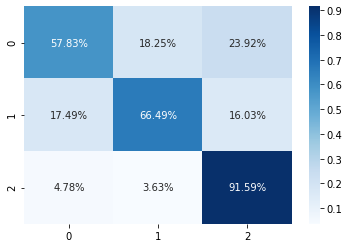

In [174]:
list1 = generateModel(X_bert, y, 'bert', 'linear_svc')

In [163]:
determineHyperparameters(X_bert, y, 'bert', 'rbf')

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:281: UserWarning: The total space of parameters 8 is smaller than n_iter=10. Running 8 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3

{'C': 1.0, 'max_iter': 500}

{'max_iter': 500, 'C': 1.0}


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base

Accuracy: 0.8062094067788019
Logistic Regression [TP, FP, TN, FN, recall, precision, f1: 
[0.78843852 0.21156148 0.85946407 0.14053593 0.84812959 0.78843852
 0.8161947 ]


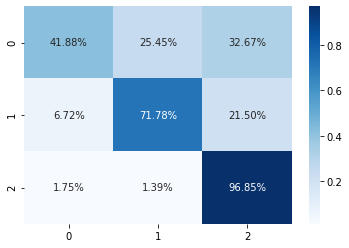

In [173]:
hyperparameter_list = np.load(f'rbf_bert_params.npy', allow_pickle=True).item()

print(hyperparameter_list)

list2 = generateModel(X_bert, y, 'bert', 'rbf')


In [168]:
determineHyperparameters(X_bert, y, 'bert', 'logistic')


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:281: UserWarning: The total space of parameters 8 is smaller than n_iter=10. Running 8 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of

ValueError: ignored

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


Accuracy: 0.7999424116150095
Logistic Regression [TP, FP, TN, FN, recall, precision, f1: 
[0.63929676 0.36070324 0.89184144 0.10815856 0.85522027 0.63929676
 0.73136883]


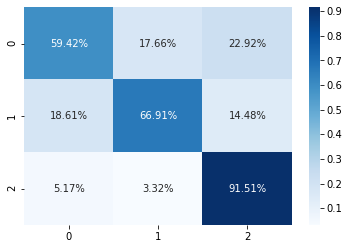

In [175]:
list3 = generateModel(X_bert, y, 'bert', 'logistic')